<a href="https://colab.research.google.com/github/KamonohashiPerry/DeepLearningWithKeras/blob/master/Chapter4_%E7%95%B0%E5%B8%B8%E6%A4%9C%E7%9F%A5%E3%81%AE%E3%82%B3%E3%83%BC%E3%83%89.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

+ 点異常
 + 分布から異常に外れたもの
+ 文脈依存型異常
 + 時系列の過程での異常
+ 集団型異常
 + 一連のデータのなかでの異常

+ 教師あり異常検知
+ 半教師あり異常検知
+ 教師なし異常検知

In [1]:
pip install changefinder

     |████████████████████████████████| 154 kB 9.4 MB/s 
  Created wheel for changefinder: filename=changefinder-0.3-py3-none-any.whl size=3841 sha256=8326e0d5d3ebb66569c6c86e5fc70d58bef5eab9b6d98029952e949344d4409a
  Stored in directory: /root/.cache/pip/wheels/48/8f/4c/ba040e4cad3dbf0409c5c38ac9d3f92f947ea490412cdf3400
Successfully built changefinder


In [2]:
import numpy as np
import matplotlib.pyplot as plt

import scipy

import changefinder

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 変化点検出

In [3]:
data = np.concatenate(
                                  [np.random.normal(0.7, 0.05, 300),
                                  np.random.normal(1.5, 0.05, 300),
                                  np.random.normal(0.6, 0.05, 300),
                                  np.random.normal(1.3, 0.05, 300)]
                                  )

In [4]:
data

array([0.76980288, 0.75549232, 0.66415778, ..., 1.28881671, 1.25790608,
       1.32670558])

In [5]:
# r：忘却パラメータ
# order：ARモデルの次数
# smooth：スコアの平滑化のウィンドウ幅
cf = changefinder.ChangeFinder(r=0.01, order=1, smooth=7)

In [6]:
result = np.empty(len(data))
for i, d in enumerate(data):
  # スコア
  result[i] = cf.update(d)

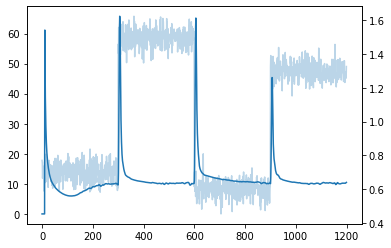

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(result, label="score")
ax2 = ax.twinx()
ax2.plot(data, alpha=0.3, label="observation");

In [8]:
cf_2 = changefinder.ChangeFinder(r=0.01, order=1, smooth=7)

In [9]:
data_2 = np.array([0, 0, 0, 2, 3, 100, 100, 115, 112, 117, 120, 115, 125, 140, 5, 4, 0])

In [10]:
data_2

array([  0,   0,   0,   2,   3, 100, 100, 115, 112, 117, 120, 115, 125,
       140,   5,   4,   0])

In [11]:
result_2 = np.empty(len(data_2))
for i, d in enumerate(data_2):
  # スコア
  result_2[i] = cf_2.update(d)

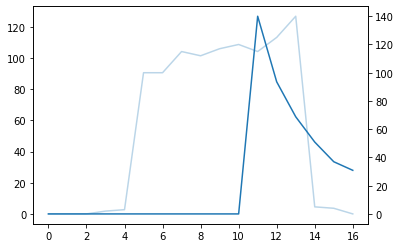

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(result_2, label="score")
ax2 = ax.twinx()
ax2.plot(data_2, alpha=0.3, label="observation");

## Bayesian Online Change Point Detection

+ https://arxiv.org/pdf/0710.3742.pdf

In [13]:
class BayesianOnlineChangePointDetection(object):
    T = 0 # 観測時間

    def __init__(self, hazard_func, distribution):
        self.beliefs = np.zeros((2, 2))
        self.beliefs[0, 0] = 1.
        # ハザード関数と連長に関する確率密度分布は引数として与える
        self.hazard_func = hazard_func
        self.distribution = distribution

    def reset_params(self):
          """
          パラメタを初期状態にリセット
          """
          self.T = 0
          self.beliefs = np.zeros((2, 2))
          # 例では初期状態で連長が必ず0になるので信念の初期状態は1.0
          self.beliefs[0, 0] = 1.

    def _expand_belief_matrix(self):
          """
          観測時点数に合わせて信念行列beleifを大きくする
          """
          n_row, n_col = self.beliefs.shape
          rows = np.zeros((1, 2))
          cols = np.zeros((n_row+1, 1))
          self.beliefs = np.concatenate((self.beliefs, rows), axis=0)

    def _shift_belief_matrix(self):
          """
          信念行列の更新
          """
          current_belief = self.beliefs[:, 0]
          self.beliefs[:, 0] = self.beliefs[:, 1]
          self.beliefs[:, 1] = 0
          return current_belief

    def _update_beliefs(self, hazard, pred_probs):
        """
        信念（連長分布）の更新
        """
        self._expand_belief_matrix()

        # 連長の増加確率の計算（次の時点で連長が+1になる確率）
        self.beliefs[1:self.T+2, 1] = self.beliefs[:self.T+1, 0]*pred_probs*(1 - hazard)

        # 変化点確率の計算（次時点で連長が0になる確率）
        self.beliefs[0, 1] = (self.beliefs[:self.T+1, 0]*pred_probs*hazard).sum()

        # 信念（連長分布）の正規化
        self.beliefs[:, 1] = self.beliefs[:, 1] / self.beliefs[:, 1].sum()

    def update(self, x):
      """
      予測分布、ハザード関数、連長分布、観測時間の更新
      """
      # 予測分布の評価
      pred_probs = self.distribution.pdf(x)

      # ハザード関数の評価
      hazard = self.hazard_func(np.arange(self.T+1))

      # 連長分布、信念の更新
      self._update_beliefs(hazard, pred_probs)

      # 十分統計量（ここではハイパーパラメタと同義）の更新
      self.distribution.update_params(x)

      # 信念が最大のindexを取得（最も可能性の高い連長を取得）
      max_belief_idx = np.where(self.beliefs[:, 0]==self.beliefs[:, 0].max())[0]

      # 現在の信念の取得
      current_belief = self._shift_belief_matrix()

      self.T += 1
      return max_belief_idx, current_belief

In [14]:
class StudentT(object):
    def __init__(self, mu0=0, kappa0=1, alpha0=1, beta0=1):
        """
        パラメタの初期化
        """
        self.mu0 = np.array([mu0])
        self.kappa0 = np.array([kappa0])
        self.alpha0 = np.array([alpha0])
        self.beta0 = np.array([beta0])
        self.reset_params()

    def reset_params(self):
        """
        パラメタを初期状態にリセット
        """
        self.muT = self.mu0.copy()
        self.kappaT = self.kappa0.copy()
        self.alphaT = self.alpha0.copy()
        self.betaT = self.beta0.copy()

    def pdf(self, x):
        """
        確率密度関数
        確率密度分布のある点（x）における確率を返す
        """
        return scipy.stats.t.pdf(x - self.muT,
                                            np.power(2*self.alphaT, 0.5))
        
    def update_params(self, x):
        """
        パラメタ（十分統計量）の更新
        それぞれのパラメタベクトルは観測点分のベクトルとなる
        """
        self.muT = np.concatenate([self.mu0, (self.kappaT * self.muT + x) / (self.kappaT + 1)])
        self.kappaT = np.concatenate([self.kappa0,  self.kappaT + 1])
        self.alphaT = np.concatenate([self.alpha0, self.alphaT + 0.5])
        self.betaT = np.concatenate([self.beta0, (self.kappaT \
                                                 + (self.kappaT * (x - self.muT)**2) / (2 * (self.kappaT + 1)))])


In [15]:
def constant_hazard(r, _lambda):
    """
    ハザード関数
    予測分布が指数関数の場合は観測時点のみに依存
    1/_lambda

    Args:
      r: 観測時間（no.ndarray or scalar）
      _lambda: ハイパーパラメタ（float）

    Returns:
      p: 変化点である確率（np.ndarray with shape = r.shape）
    """
    if isinstance(r, np.ndarray):
        shape = r.shape
    else:
        shape = 1

    # 変化点確率の計算
    probability = np.ones(shape) / _lambda
    return probability

In [16]:
data_3 = np.concatenate(
                                      [np.random.normal(0.7, 0.05, 300), 
                                      np.random.normal(1.5, 0.05, 300),
                                      np.random.normal(0.6, 0.05, 300),
                                      np.random.normal(1.3, 0.05, 300)
                                      ])

In [17]:
test_signal = data_2

In [18]:
# ハザード関数
hazard_func = lambda r : constant_hazard(r, _lambda=30)

# 確率密度関数としてステューデントのt分布を用いる
distribution = StudentT()

# 予測分布の確率密度関数の初期化
distribution.reset_params()

bcp = BayesianOnlineChangePointDetection(hazard_func=hazard_func, distribution=distribution)
bcp.reset_params()

maxes = np.empty(test_signal.shape)
beliefs = []

# 例では連長の初期状態が必ず0になり、信念は1.0になることがわかっているため
# 信念の初期状態を格納しておく
beliefs.append(bcp.beliefs[:, 0])

# 推定連長と信念の計算
for i, d in enumerate(test_signal):
  maxes[i], current_belief = bcp.update(d)
  beliefs.append(current_belief)

In [19]:
max_len = beliefs[-1].shape[0]
belief_matrix = np.zeros((max_len - 1, max_len - 1))

for i, belief in enumerate(beliefs):
  belief_matrix[:i+1, i] = belief[:-1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


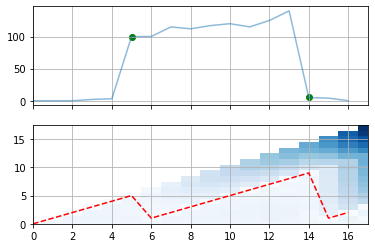

In [20]:
fig, ax = plt.subplots(nrows=2, sharex=True)

ax[0].plot(test_signal, alpha=0.5, label="observation")
ax[1].imshow(-np.log(belief_matrix), interpolation='none', aspect='auto',
                    origin='lower', cmap=plt.cm.Blues, label="belief")
ax[1].plot(maxes, '--', color='r', label="run length")
ax[1].set_xlim([0, len(test_signal)])
ax[1].set_ylim([0, ax[1].get_ylim()[1]])
ax[0].grid()
ax[1].grid()
index_changes = np.where(np.diff(maxes) < 0)[0]
ax[0].scatter(index_changes, test_signal[index_changes],
                    c='green', label='change point');

## 深層学習を用いた異常検知
+ EncDec-AD

In [33]:
pip install tensorflow==2.0.0-alpha0

In [137]:
import tensorflow as tf
from tensorflow.python.eager import context
import argparse
import sys
import time

In [138]:
class FRNN(tf.keras.Model):
    """
    エンコーダー
    """

    def __init__(self, hidden_dim):
        super().__init__()
        # v2.0 alpha版ではtf.keras.layersとtf.nnで完全な互換性がない
        # 一部v1.xのクラスを使用している
        self.lstm = tf.compat.v1.nn.rnn_cell.LSTMCell(num_units=hidden_dim,
                                                                            state_is_tuple=True)
        
    def call(self, input_seq):
        batch_size = input_seq.shape[1]
        # LSTMの状態初期化
        state = self.lstm.zero_state(batch_size, tf.float32)

        X = tf.transpose(input_seq, [1, 0, 2])
        _, state = tf.compat.v1.nn.dynamic_rnn(self.lstm,
                                                                    X,
                                                                    initial_state=state)
        return state

In [139]:
class BRNN(tf.keras.Model):
    """
    デコーダー
    """

    def __init__(self, hidden_dim, n_dim_obs=1, training=True):
        super().__init__()
        # デコーダー側のLSTM
        self.lstm = tf.compat.v1.nn.rnn_cell.LSTMCell(num_units=hidden_dim,
                                                                            state_is_tuple=True)
        # 隠れ層の状態をもとに出力値を計算するための全結合層
        self.out_linear = tf.keras.layers.Dense(
                                                                  n_dim_obs,
                                                                  kernel_initializer=tf.random_uniform_initializer(-0.1, 0.1)
                                                                )
        # 教師データを入力しLSTMの隠れ層の次元に合わせる全結合層
        self.shape_linear = tf.keras.layers.Dense(
                                                                    hidden_dim,
                                                                    activation=tf.tanh,
                                                                    kernel_initializer=tf.random_uniform_initializer(-0.1, 0.1)
                                                                    )
        self.n_dim_obs = n_dim_obs
        self.training = training

    def predict(self, state, seq_size):
        """
        推論用のメソッド
        """
        outputs = []
        # t時点の出力
        # stateは[hidden_state, cell_state]を保持している
        output = self.out_linear(state[0])
        outputs.insert(0, output)
        for _ in range(1, seq_size):
            # 次元をLSTMの隠れ状態に合わせる
            inp = self.shape_linear(output)
            _, shape = self.lstm(inp, state)

            # 隠れ状態から出力値を算出する
            output = self.out_linear(state[0])
            outputs.insert(0, output)
        return outputs
        
    def train(self, input_seq, state, seq_size):
        """
        訓練用のメソッド
        predict とほぼ同じ処理だが、観測データを使ってデコードする
        """

        outputs = []
        output = self.out_linear(state[0])
        outputs.insert(0, output)
        for t in reversed(range(1, seq_size)):
              inp = self.shape_linear(input_seq[t])
              out, state = self.lstm(inp, state)
              output = self.out_linear(state[0])
              outputs.insert(0, output)
        return outputs

    def call(self, f_lstm_latest_state, seq_size, input_seq=None):
        batch_size = f_lstm_latest_state[0].shape[0]
        # LSTMの状態の初期化
        self.lstm.zero_state(batch_size, tf.float32)

        # エンコーダーの最後の状態をデコーダーの初期状態とする
        state = f_lstm_latest_state[0]

        # 訓練
        if self.training:
              outputs = self.train(input_seq, f_lstm_latest_state, seq_size)

        # 推論
        else:
              outputs = self.predict(f_lstm_latest_state, seq_size)

        return tf.stack(outputs, axis=0)


In [140]:
class EncDecAD(tf.keras.Model):
    """
    EncDec-ADの本体
    """

    def __init__(self,
                      hidden_dim,
                      n_dim_obs=1,
                      training=True):
        super().__init__()

        # 観測値の次元
        self.n_dim_obs = n_dim_obs
        # エンコーダー
        self.f_lstm = FRNN(hidden_dim)
        # デコーダー
        self.b_lstm = BRNN(hidden_dim, n_dim_obs, training)
        self.training = training

    def reset(self, training):
        self.b_lstm.training = training

    def call(self, input_seq, training=True):
        # エンコーダー/デコーダーのtrainingオプションの初期化
        self.reset(training)

        batch_size = input_seq.shape[1]
        seq_size = input_seq.shape[0]

        # エンコーダー側の処理の実行
        h = self.f_lstm(input_seq)

        # デコーダー側の処理の実行
        outputs = self.b_lstm(h, seq_size, input_seq=input_seq)
        return outputs

In [141]:
def loss_fn(model, inputs, targets, training):
    """
    損失計算メソッド
    """
    seq_len, b_size, n_dim_obs = inputs.shape
    labels = tf.reshape(targets, [-1])
    outputs = model(inputs, training)
    # データ長に影響されるためmean_squared_errorは使えない
    # 愚直に二乗平方和を計算する
    individual_losses = tf.math.reduce_sum(
                                                                tf.math.squared_difference(outputs, targets), axis=1
                                                              )
    loss = tf.math.reduce_sum(individual_losses)
    return loss, outputs

def anomaly_score(outputs, targets, normal_data):
    """
    異常スコアの計算メソッド
    """
    seq_length, batch_size, n_dim_obs = targets.shape

    eval_residual = np.abs(outputs - targets)
    normal_residual = np.abs(outputs - normal_data)

    res_mu = normal_residual.mean(axis=(0, 1))
    res_sig = normal_residual.std(axis=(0, 1))
    res_sig_inv = np.linalg.pinv(res_sig) if res_sig.shape[0] > 1 else 1/res_sig

    diff_mu = (eval_residual - res_mu).transpose(1, 0, 2).reshape(-1, n_dim_obs)
    if len(res_sig_inv) == 1:
        scores = diff_mu / res_sig_inv * diff_mu
    else:
        scores = diff_mu.dot(res_sig_inv) * diff_mu
    return scores.sum(axis=1)

In [142]:
class Datasets(object):
    """
    ダミーデータの生成
    """
    def __init__(self):
        # 訓練データ
        t = np.linspace(0, 5*np.pi, 500)
        self.train = 10*np.sin(t).reshape(-1, 1)
        self.train = np.tile(np.abs(self.train), (32, 1)).astype('f')

        # テストデータ
        t = np.linspace(0, 4*np.pi, 400)
        self.valid = 10*np.sin(t).reshape(-1, 1)
        self.valid = np.concatenate(
                                                  (np.random.randn(100).reshape(100, 1), self.valid),
                                                    axis=0
                                                )
        self.valid = np.tile(np.abs(self.valid), (4, 1)).astype('f')

In [143]:
def _divide_into_batches(data, batch_size):
    """
    系列データをEncDec-ADへの入力用に整形する
    """
    n_time, n_dim_obs = data.shape
    nbatch = n_time // batch_size
    data = data[:nbatch * batch_size]
    data = data.reshape(batch_size, -1, n_dim_obs).transpose((1, 0, 2))
    return data

def _get_batch(data, i, seq_len):
    """
    バッチごとにデータを取得する
    """
    slen = min(seq_len, data.shape[0] - i)
    inputs = data[i:i + slen]
    target = inputs.copy()

    # tensorflowのopに変換
    # dataは変換ではないので、constantとする
    return tf.constant(inputs), tf.constant(target)

In [144]:
def train(model, optimizer, train_data, sequence_length, clip_ratio, training=True):
    """
    1エポック分の学習
    """

    def model_loss(inputs, targets):
        return loss_fn(model, inputs, targets, training=training)[0]

    total_time = 0
    batch_start_idx_range = range(0, train_data.shape[0] - 1, sequence_length)

    for batch, i in enumerate(batch_start_idx_range):
        # バッチごとにデータを取得
        train_seq, train_target = _get_batch(train_data, i, sequence_length)
        start = time.time()
        with tf.GradientTape() as tape:
            loss, _ = loss_fn(model, train_seq, train_target, training)

        # 勾配計算
        grads = tape.gradient(loss, model.trainable_variables)

        # パラメタ更新
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        total_time += (time.time() - start )
        if batch % 10 == 0:
            time_in_ms = (total_time * 1000) / (batch + 1)
            sys.stderr.write(
                                    "batch %d: training loss %.2f, avg step time %d ms\n" %
                                      (batch, model_loss(train_seq, train_target).numpy(),
                                       time_in_ms)
                                  )

In [145]:
def evaluate(args, model, eval_data, train_data, training=True):
    """
    エポックごとの評価
    損失と異常スコアを計算
    """
    total_loss = 0.0
    total_batches = 0
    start = time.time()
    l_scores = []
    for _, i in enumerate(range(0, eval_data.shape[0], args.seq_len)):
        # バッチごとにデータを取得
        inp, target = _get_batch(eval_data, i, args.seq_len)

        # 損失関数
        loss, outputs = loss_fn(model, inp, target, training=training)
        total_loss += loss.numpy()
        total_batches += 1

        _, batch_size, _ = inp.shape
        # 異常スコアの計算
        scores = anomaly_score(outputs, target, train_data[:, :batch_size])
        l_scores.append(scores)


    time_in_ms = (time.time() - start) * 1000
    sys.stderr.write("eval loss %.2f (eval took %d ms)\n" %
                            (total_loss / total_batches, time_in_ms))
    return total_loss, l_scores, outputs

In [146]:
pwd

'/content'

In [147]:
ls

sample_data/


In [148]:
def main(args):
    if not args.data_path:
        raise ValueError("Must specify --data-path")

    # データセットの読み出し
    data = Datasets()
    # EncDec-ADへの入力用に整形した訓練データの作成
    train_data = _divide_into_batches(data.train, args.batch_size)
    # EncDec-ADへの入力用に整形したテストデータの作成
    eval_data = _divide_into_batches(data.valid, args.eval_batch_size)

    # GPUの有無の確認
    have_gpu = context.num_gpus() > 0

    # デバイスの割り当て（GPUデバイスが検出されない場合は使わない）
    with tf.device("/device:GPU:0" if have_gpu else None):
        # 学習係数
        # 学習係数は変化するのでVariableで定義
        learning_rate = tf.Variable(args.learning_rate, name="learning_rate")
        sys.stderr.write("learning_rate=%f\n" % learning_rate.numpy())

        # EncDecADクラスのインスタンス作成
        model = EncDecAD(args.hidden_dim, args.training)
        # オプティマイザオブジェクトの作成
        optimizer = tf.keras.optimizers.Adam(learning_rate)

        best_loss = None
        cnt = 0
        # エポックごとののループ
        for _ in range(args.epoch):
            # 訓練
            train(model, optimizer, train_data, args.seq_len, args.clip)
            # 評価
            eval_loss, l_scores, outputs = evaluate(args,
                                                                      model,
                                                                      eval_data,
                                                                      train_data)
            # テストデータを使った評価での損失が下がった場合
            if not best_loss or eval_loss < best_loss:
                best_loss = eval_loss
                cnt = 0

            # テストデータを使った評価での損失が下がらなかった場合
            else:
                cnt += 1
                # 6回連続で下がらなかった場合
                if cnt > 5:
                    # 学習係数を1/1.2倍する
                    learning_rate.assign(max(learning_rate/1.2, .002))
                    sys.stderr.write(
                                            "eval_loss did not reduce in this epoch, "
                                            "changing learning rate to %f for the next epoch\n" %
                                            learning_rate.numpy()
                                            )
                    cnt = 0

        scores = l_scores[0]
        for score in l_scores[1:] :
            scores = np.concatenate([scores, score])

        # 結果の表示
        plt.plot(data.train[:len(data.valid)],
                    color='g', alpha=0.5, label="normal")
        plt.plot(data.valid,
                    ':', color='b', alpha=0.5, label="normal")
        plt.plot(outputs.numpy().transpose(1, 0, 2).flatten(),
                    '--', color='y', label="predict")
        plt.plot(scores, '+-', color='r', alpha=0.3, label="score")
        plt.show()

In [149]:
parser = argparse.ArgumentParser()
parser.add_argument(
    "--data-path",
    type=str,
    default="./src/chapter04/simple-examples/data",
    help="Data directory path")
parser.add_argument(
    "--learning-rate", type=float, default=.05, help="Learning rate.")
parser.add_argument(
    "--epoch", type=int, default=200, help="Number of epoches.")
parser.add_argument(
    "--batch-size", type=int, default=32, help="Batch size.")
parser.add_argument(
    "--eval-batch-size", type=int, default=4, help="Batch size.")
parser.add_argument(
    "--seq-len", type=int, default=500, help="Sequence length.")
parser.add_argument(
    "--hidden-dim", type=int, default=10, help="Hidden layer dimension.")
parser.add_argument(
    "--clip", type=float, default=0.3, help="Gradient clipping ratio.")
parser.add_argument(
    "--training", type=bool, default=True, help="Training or not.")

args, unparsed = parser.parse_known_args()

In [150]:
args

Namespace(batch_size=32, clip=0.3, data_path='./src/chapter04/simple-examples/data', epoch=200, eval_batch_size=4, hidden_dim=10, learning_rate=0.05, seq_len=500, training=True)

learning_rate=0.050000
batch 0: training loss 675430.56, avg step time 2703 ms
eval loss 67760.18 (eval took 741 ms)
batch 0: training loss 333077.44, avg step time 1836 ms
eval loss 33437.95 (eval took 732 ms)
batch 0: training loss 87436.62, avg step time 1932 ms
eval loss 10651.28 (eval took 742 ms)
batch 0: training loss 244014.42, avg step time 1793 ms
eval loss 29568.26 (eval took 717 ms)
batch 0: training loss 82467.05, avg step time 1925 ms
eval loss 10912.15 (eval took 726 ms)
batch 0: training loss 141475.25, avg step time 1770 ms
eval loss 15614.75 (eval took 753 ms)
batch 0: training loss 161315.06, avg step time 1937 ms
eval loss 17333.69 (eval took 738 ms)
batch 0: training loss 121966.05, avg step time 1794 ms
eval loss 13560.68 (eval took 723 ms)
batch 0: training loss 69028.59, avg step time 2034 ms
eval loss 8742.35 (eval took 738 ms)
batch 0: training loss 78904.12, avg step time 1797 ms
eval loss 10362.72 (eval took 730 ms)
batch 0: training loss 95373.29, avg step 

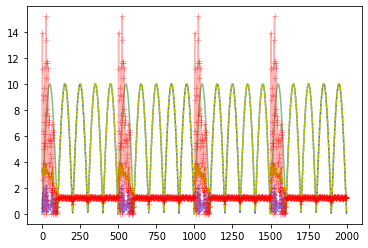

CPU times: user 11min 17s, sys: 2.26 s, total: 11min 19s
Wall time: 11min 20s


In [151]:
%%time
main(args)